# Intro to deep learning
In this notebook we'll expand on the Optimization notebook. We will go over some basic MNIST tasks (autoencoders, and classification), learning rates, normalization, etc. 

In [1]:
import numpy as np
from einops import rearrange
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torch.utils.data
from tqdm import tqdm

In [2]:
trainingdata = torchvision.datasets.MNIST('./MNIST',train=True, transform=torchvision.transforms.ToTensor(), download=True)
testdata = torchvision.datasets.MNIST('./MNIST',train=False, transform=torchvision.transforms.ToTensor(), download=True)

torch.Size([1, 28, 28]) 8


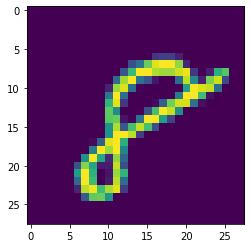

In [3]:
image, label = trainingdata[59999]
print(image.shape, label)

plt.imshow(image.squeeze().numpy())
plt.show()

In [4]:
traindataloader = torch.utils.data.DataLoader(trainingdata, batch_size=64, shuffle=True)
testdataloader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=False)

In [5]:
images, labels = iter(traindataloader).__next__()
print(images.size(), labels)

torch.Size([64, 1, 28, 28]) tensor([0, 0, 7, 6, 7, 0, 6, 8, 6, 7, 7, 0, 8, 1, 2, 1, 5, 3, 9, 6, 4, 7, 5, 2,
        5, 6, 0, 9, 2, 9, 1, 4, 5, 9, 6, 8, 1, 8, 0, 0, 0, 5, 6, 8, 0, 7, 2, 7,
        4, 3, 9, 5, 0, 5, 5, 9, 7, 7, 1, 5, 1, 1, 9, 1])


In [6]:
class LR(torch.nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.linear1 = torch.nn.Linear(28*28, 128) # W:784x128 , b:128x1 , parameters = [W,b]
        self.linear2 = torch.nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1,28*28)
        transformed_x1 = F.relu(self.linear1(x))
        transformed_x2 = self.linear2(transformed_x1)
        return transformed_x2
net = LR().cuda()
print("Number of parameters: ", sum(p.numel() for p in net.parameters()))
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

Number of parameters:  101770


In [7]:
from torchmetrics import Accuracy
accuracy = Accuracy(task='multiclass',num_classes=10).cuda()

train_loss_history = []
test_loss_history = []
test_accuracy = []

for epoch in range(25):
    train_loss = 0.0
    test_loss = 0.0
    test_acc = 0.0
    for i, data in enumerate(traindataloader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = net(images)
        loss = criterion(predicted_output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    for i, data in enumerate(testdataloader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = net(images)
            loss = criterion(predicted_output, labels)
            test_loss += loss.item()
            test_acc += accuracy(predicted_output, labels).item()
    train_loss = train_loss/len(traindataloader)
    test_loss = test_loss/len(testdataloader)
    test_acc = test_acc/len(testdataloader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_accuracy.append(test_acc)
    print('Epoch %s finished with train loss %s and test loss %s'%(epoch, train_loss, test_loss))

Epoch 0 finished with train loss 1.2550716542168212 and test loss 0.5938261793867038
Epoch 1 finished with train loss 0.4987423179277987 and test loss 0.4072872871521172
Epoch 2 finished with train loss 0.39532344478533976 and test loss 0.3508535078756369
Epoch 3 finished with train loss 0.3539132017856722 and test loss 0.32251826697474073


KeyboardInterrupt: 

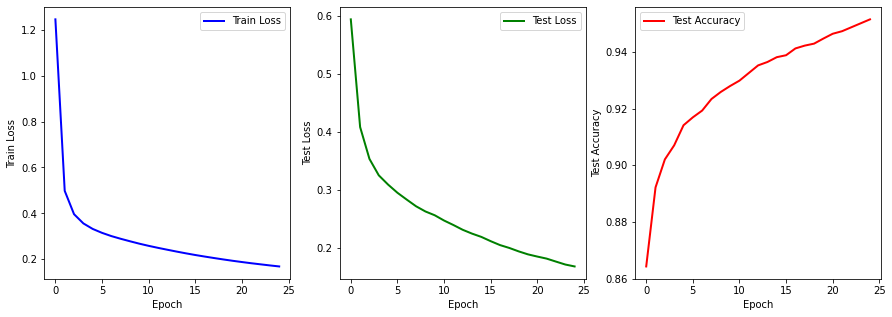

In [8]:
# Init figure w/ subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the training loss curve in the first subplot
ax1.plot(train_loss_history, label='Train Loss', color='blue', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss')
ax1.legend()

# Plot the accuracy curve in the second subplot
ax2.plot(test_loss_history, label='Test Loss', color='green', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Test Loss')
ax2.legend()

# Plot the accuracy curve in the second subplot
ax3.plot(test_accuracy, label='Test Accuracy', color='red', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Test Accuracy')
ax3.legend()

plt.show()

In [9]:
predicted_output = net(images)
print(predicted_output[1])
print(torch.max(predicted_output, 1)[1])
loss = criterion(predicted_output, labels)
print(labels)
print(loss)

tensor([-4.4580, -2.0368,  8.9247,  4.5789, -5.4097, -1.6326, -6.1767,  3.5305,
         3.5159, -1.8981], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1, 2, 8, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6], device='cuda:0')
tensor(0.0643, device='cuda:0', grad_fn=<NllLossBackward0>)


# Autoencoders

Autoencoders are a type of neural network that is often used to find compact latent representations for some high dimensional data. 
They do this by mapping the high dimensional data down to some much smaller footprint, and then to 'decode' or build that small footprint back up into the original size. You typically optimize autoencoders with a simple reconstruction loss. In the case of images, you take the mean squared error between the neural network's input and the output it produced. Autoencoder's have two main ideas
* You create a small enough bottleneck that the network must learn efficient latent representations
* If the network is able to perfectly decode your latent representation, then you probably have some efficient latent representation. If the network can't reconstruct the input, then the latent representations must be noisy.
An immediate question that comes to mind is: Why would we want to generate a copy of the input if we already have the input? Compression.
Compression is the abstracted idea behind 'efficient latent representations'. By compressing the original input image down to the size of our predefined latent space, we are asking the question; How few numbers can I use to represent this specific sample? In doing so the network is forced to learn only the most important features of the image. 
Autoencoders are used in all sorts of applications in deep learning. Most notably, Large Language Models, DALLE, and Stable Diffusion.

In [15]:
# start off by defining multiple modules that encompass our autoencoder

# The encoder will take the ground truth sample as input and project it down into some smaller latent representation.
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(490, 2)
        self.c1 = nn.Conv2d(1, 5, 4, 2, 1)
        self.c2 = nn.Conv2d(5, 10, 4, 2, 1)
        
    def forward(self, x):
        x = self.c2(F.relu(self.c1(x)))
        x = x.flatten(1)
        x = self.l1(F.relu(x))
        return x
    
# The decoder will take the encoded latent representation as input and predict what the original input to the encoder block was
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(2, 490)
        self.cT2 = nn.ConvTranspose2d(10, 5, 2, 2)
        self.cT1 = nn.ConvTranspose2d(5, 1, 2, 2)
        
    def forward(self, x):
        x = torch.sin(self.l1(x))
        x = rearrange(x, 'b (c h w) -> b c h w', c=10, h=7, w=7)
        x = self.cT1(F.relu(self.cT2(x)))
        return x
    
    
# For ease of use we package the encoder and decoder into a single module
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        latents = self.encoder(x)
        recon = self.decoder(latents)
        return recon, latents

In [11]:
# Define our training loop
def train_loop(data_loader, ae, opt, device):
    running_loss = 0.0
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        recon, _ = ae(images)
        loss = F.mse_loss(recon, images)
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

def test_loop(data_loader, ae, device):
    ae.eval()
    running_loss = 0.
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        recon, _ = ae(images)
        loss = F.mse_loss(recon, images)
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [12]:
# locate our GPU device and initialize it for training
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Init all of our models
ae = AE()
ae.to(device)
print("Number of parameters: ", sum(p.numel() for p in ae.parameters()))

opt = torch.optim.Adam(ae.parameters(), lr=3e-4)

for i in range(10):
    loss_rec = train_loop(traindataloader, ae, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)
    loss_rec_test = test_loop(testdataloader, ae, device)
    print('test loss: ', loss_rec_test)

Number of parameters:  33003
loss from epoch  0 :  0.06121311198348112
test loss:  0.02449356702862272
loss from epoch  1 :  0.019592308449243177
test loss:  0.01599508407080819
loss from epoch  2 :  0.015013693161666203
test loss:  0.013659628416607334
loss from epoch  3 :  0.013449091919020675
test loss:  0.012625643669087796
loss from epoch  4 :  0.012558855275228334
test loss:  0.011840342899938678
loss from epoch  5 :  0.01182510899300419
test loss:  0.011139898810084838
loss from epoch  6 :  0.011125096177527391
test loss:  0.010527148913995475
loss from epoch  7 :  0.010615743968739056
test loss:  0.01015576933196206
loss from epoch  8 :  0.010303557504897814
test loss:  0.00988764536810244
loss from epoch  9 :  0.010047774480929824
test loss:  0.009657165115687307


In [13]:
ae.eval()
image, label = trainingdata[59999]
pred = ae(image.to(device).unsqueeze(0))

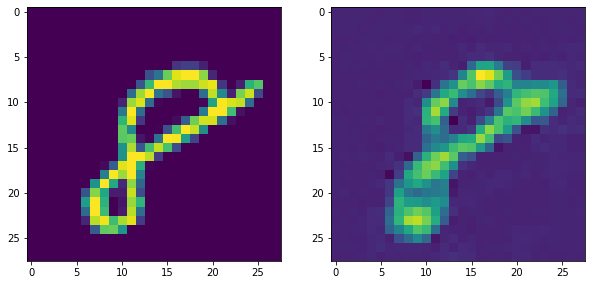

In [14]:
# Init figure w/ subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(image.squeeze().numpy())
ax2.imshow(pred[0].detach().cpu().squeeze().squeeze().numpy())

From our loss values, this is fairly surprising. We had final loss values on the test dataset of 0.01, but our model outputs a blurry version of the input. 
This is fairly intuitive when you think about autoencoders, by bottlenecking the amount of information the network is allowed to let through, maybe only the lower frequency features are going to pass through. This also highlights one of the downfalls of autoencoders; they frequently fall to the mean. 

### Visualizing latent representations
PCA and TSNE were addressed earlier in the course, and are show in the DataPreparation notebook. Autoencoders can be viewed as another method for dimensionality reductions, but as a highly nonlinear approach.
Below, we train an autoencoder with a bottleneck size of 2 (to match the PCA example) and visualize beside the PCA results of the same subset of data. 

In [16]:
# Define our training loop
def train_loop(data_loader, ae, opt, device):
    running_loss = 0.0
    for data in data_loader:
        images, _ = data
        images = images.to(device) # need to move data onto GPU for acceleration (data must be on same device as model)
        recon, _ = ae(images)
        loss = F.mse_loss(recon, images)
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

def test_loop(data_loader, ae, device):
    ae.eval()
    running_loss = 0.
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        recon, _ = ae(images)
        loss = F.mse_loss(recon, images)
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [17]:
# locate our GPU device and initialize it for training
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Init all of our models
ae = AE()
ae.to(device) # need to move the model onto the GPU for acceleration
print("Number of parameters: ", sum(p.numel() for p in ae.parameters()))

opt = torch.optim.Adam(ae.parameters(), lr=3e-4)

for i in range(10):
    loss_rec = train_loop(traindataloader, ae, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)
    loss_rec_test = test_loop(testdataloader, ae, device)
    print('test loss: ', loss_rec_test)

Number of parameters:  3573
loss from epoch  0 :  0.1265336632299652
test loss:  0.0661467616535296
loss from epoch  1 :  0.06143580136427493
test loss:  0.05966175826871471
loss from epoch  2 :  0.058530778117747956
test loss:  0.05811003424749253
loss from epoch  3 :  0.057350164942586344
test loss:  0.05712503709705772
loss from epoch  4 :  0.05648644629524334
test loss:  0.0563938663975828
loss from epoch  5 :  0.05576005352458466
test loss:  0.055617602055619476
loss from epoch  6 :  0.05510785907649918
test loss:  0.05504504206833566
loss from epoch  7 :  0.05458935635732308
test loss:  0.05455523954739996
loss from epoch  8 :  0.05414085475795432
test loss:  0.05412814018737738
loss from epoch  9 :  0.053677418902675224
test loss:  0.05355996913780832


torch.Size([10000, 28, 28]) torch.Size([10000])


/tmp/ipykernel_3275/2094236143.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ae_in = torch.tensor(pics[:10000], dtype=torch.float32).to(device).unsqueeze(1)


Text(0.5, 1.0, 'Autoencoder')

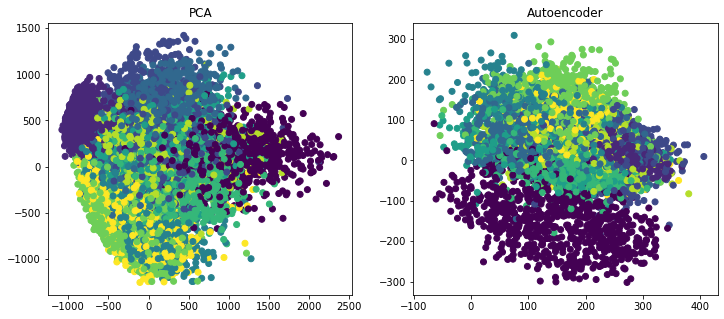

In [18]:
from sklearn.decomposition import PCA

mnist = testdata._load_data()

(pics, labels) = mnist
print(pics.shape, labels.shape)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pics[:10000].reshape(10000,28*28))

ae_in = torch.tensor(pics[:10000], dtype=torch.float32).to(device).unsqueeze(1)
ae.eval()
with torch.no_grad():
    _, latents = ae(ae_in)
    
# need to detach output from A.D. computational graph, move to cpu for plotting, remove channel dimension and switch from torch tensor to numpy array
ae_result = latents.detach().cpu().squeeze().numpy()


# Init figure w/ subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(pca_result[:,0], pca_result[:,1], c=labels[:10000], label='PCA')
ax1.set_title('PCA')
ax2.scatter(ae_result[:,0], ae_result[:,1], c=labels[:10000], label='Autoencoder')
ax2.set_title('Autoencoder')

# Normalization and hyperparameters tuning
Now that we have gone over a few deep learning examples with the mnist dataset (classification and autoencoders). Lets cover some of the basics when it comes to hyperparameter tuning. 
Hyperparameters is a bit of a catch-all phrase for any non-parameterized, user-adjustable parameter in your model/training framework. Examples:
* Learning rate: This is a scaling factor that determines the step size taken during optimization of the neural network weights. A high learning rate may cause the model to overshoot the optimal weights, while a low learning rate may result in slow convergence or getting stuck in a local minimum.
* Number of epochs: This is the number of times the training data is passed through the network during training. Too few epochs may result in underfitting, while too many epochs may lead to overfitting.
* Batch size: This is the number of training examples used in each update of the neural network weights. A larger batch size may lead to more accurate gradient estimates but requires more memory.
* Number of hidden layers: This is the number of layers in the neural network between the input and output layers. Adding more hidden layers can increase the capacity of the network, but can also make it more prone to overfitting.
* Activation function: This is the non-linear function applied to the output of each neuron in the network. Different activation functions can lead to different properties of the learned function.
* Dropout is a regularization technique that randomly drops out a fraction of the neurons in a network during training to prevent overfitting.
* Normalization layers can improve the stability and performance of neural networks by normalizing inputs to a layer over a mini-batch of examples, helping to prevent the internal covariate shift problem and vanishing or exploding gradients.

Since our basic classification model already gets ~95% accuracy we'll continue with the autoencoder example. 

In [91]:
# start off by defining multiple modules that encompass our autoencoder

# Let's define a small residual convolution block, with no up or downsampling to increase the depth of the network for more expressivity.
class ResidualBlock(nn.Module):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.residual_block = nn.Sequential(nn.Conv2d(10, 10, 3, stride=1, padding=1),
                                            nn.LeakyReLU(0.2, inplace=True)
                                            )

    def forward(self, x):
        return x + self.residual_block(x)


# The encoder will take the ground truth sample as input and project it down into some smaller latent representation.
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.c1 = nn.Conv2d(1, 5, 4, 2, 1)
        self.c2 = nn.Conv2d(5, 10, 4, 2, 1)
        self.res_block = []
        for _ in range(4):
            self.res_block.append(nn.Sequential(
                nn.Conv2d(10, 10, 3, stride=1, padding=1),
                nn.LeakyReLU(0.2, inplace=True))
            )
        
        self.l1 = nn.Linear(490,64)
        
    def forward(self, x):
        x = self.c2(F.relu(self.c1(x)))
        # for elem in self.res_block:
        #     x += elem(x)
        x = x.flatten(1)
        x = self.l1(F.relu(x))
        return x
    
# The decoder will take the encoded latent representation as input and predict what the original input to the encoder block was
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(64, 490)
        self.res_block = []
        for _ in range(4):
            self.res_block.append(nn.Sequential(
                nn.Conv2d(10, 10, 3, stride=1, padding=1),
                nn.LeakyReLU(0.2, inplace=True))
            )
        self.cT2 = nn.ConvTranspose2d(10, 5, 2, 2)
        self.cT1 = nn.ConvTranspose2d(5, 1, 2, 2)
        
    def forward(self, x):
        x = self.l1(x)
        x = rearrange(x, 'b (c h w) -> b c h w', c=10, h=7, w=7)
        # for elem in self.res_block:
        #     x += elem(x)
        x = self.cT1(F.relu(self.cT2(x)))
        return x
    
    
# For ease of use we package the encoder and decoder into a single module
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        latents = self.encoder(x)
        recon = self.decoder(latents)
        return recon, latents

In [94]:
# Define our training loop
def train_loop(data_loader, ae, opt, device):
    running_loss = 0.0
    for data in data_loader:
        images, _ = data
        images = images.to(device) # need to move data onto GPU for acceleration (data must be on same device as model)
        recon, _ = ae(images)
        loss = F.mse_loss(recon, images)
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

def test_loop(data_loader, ae, device):
    ae.eval()
    running_loss = 0.
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        recon, _ = ae(images)
        loss = F.mse_loss(recon, images)
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [95]:
# locate our GPU device and initialize it for training
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Init all of our models
ae = AE()
ae.to(device) # need to move the model onto the GPU for acceleration
print("Number of parameters: ", sum(p.numel() for p in ae.parameters()))

opt = torch.optim.Adam(ae.parameters(), lr=3e-4)

for i in range(1):
    loss_rec = train_loop(traindataloader, ae, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)
    loss_rec_test = test_loop(testdataloader, ae, device)
    print('test loss: ', loss_rec_test)

Number of parameters:  64395
loss from epoch  0 :  0.08463224372677584
test loss:  0.03212022208341747
